In [1]:
from data import wiki
from data import corpus
import wham

import nltk
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

posts = wiki.load_posts(recreate=False)
pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)
network = wiki.load_network(reply_pairs=pairs, recreate=False)

In [2]:
# Run post annotations for `recreate=True` in `load_posts`
# posts = corpus.tokenize_posts(posts)
# posts = corpus.pos_tag_posts(posts)
# markers = wham.load_markers()
# posts = corpus.detect_markers(posts, markers)
# wiki.save_posts(posts, overwrite=True)

# wiki.save_network(posts, overwrite=False)

# users = wiki.load_users(posts=posts, recreate=True)
# users = corpus.compute_centrality(users, network, log_normalize=True)
# wiki.save_users(users, overwrite=True)

# Prep data

In [5]:
threshold = users.centrality.mean() + users.centrality.std()
users['highly_central'] = (users['centrality'] > threshold)
print(users.highly_central.value_counts())
print(users['admin'].value_counts())

False    29007
True      1893
Name: highly_central, dtype: int64
False    29088
True      1812
Name: admin, dtype: int64


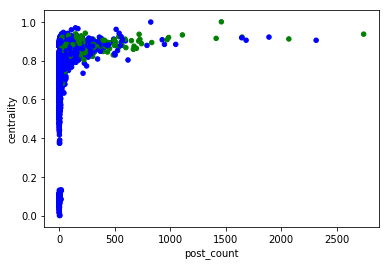

In [6]:
%matplotlib inline
import math 
cs = ['green' if user.admin else 'blue' for i,user in users.iterrows()]
users.plot.scatter('post_count', 'centrality', c=cs)

/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


([array([   2.,    4.,    0.,    0.,    0.,    9.,   82.,  580., 1034.,
           59.]),
  array([2.2200e+02, 6.3000e+01, 0.0000e+00, 4.0000e+00, 3.3000e+01,
         4.9200e+02, 5.2590e+03, 1.3889e+04, 5.2290e+03, 1.4900e+02])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

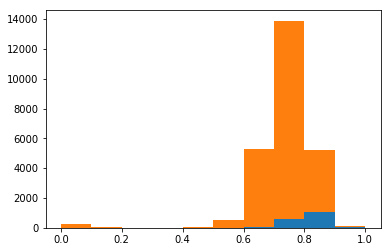

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
x1 = [user.centrality for i, user in users[users.admin].iterrows()]
x2 = [user.centrality for i, user in users[~users.admin].iterrows()]
plt.figure()
plt.hist([x1,x2], stacked=True)

In [8]:
reply_pairs = pairs.join(users, on='user_a')
subpops_column = 'speaker_power'
reply_pairs['len_b'] = reply_pairs.tokens_b.apply(len)

reply_pairs['admin_at_time'] = reply_pairs.admin_ascension < reply_pairs.timestamp_b

speaker_power_code = {(True,True):   'Both'
                     ,(True,False):  'Admin'
                     ,(False,True):  'Central'
                     ,(False,False): 'Neither'}
reply_pairs['speaker_power'] = list(zip(reply_pairs.admin_at_time, reply_pairs.highly_central))
reply_pairs['speaker_power'] = reply_pairs.speaker_power.apply(lambda x: speaker_power_code[x])

In [9]:
markers = wham.load_markers()

In [10]:
# tortured reshaping
for m in markers:
    reply_pairs[m] = list(zip(reply_pairs[m+'_a'], reply_pairs[m+'_b']))
id_vars = ['utterance_id_b', 'user_a', 'user_b', subpops_column, 'len_b']
df = pd.melt(reply_pairs, id_vars=id_vars, value_vars=markers, var_name='marker')
df = df.join(pd.DataFrame(df['value'].tolist(), columns=['count_a', 'count_b']))

df['bool_a'] = df.count_a > 0
df['bool_b'] = df.count_b > 0

df['n_base'] = df.len_b.where(~df.bool_a, 0)
df['c_base'] = df.count_b.where(~df.bool_a & df.bool_b, 0)

df['n_align'] = df.len_b.where(df.bool_a, 0)
df['c_align'] = df.count_b.where(df.bool_a & df.bool_b, 0)

In [11]:
df.to_pickle('wham_df_2018-11-20.pickle')
# df = df.read_pickle('wham_df_2018-11-20.pickle')
sample = None

# Run Stan model

In [17]:
marker_idx = {m:i+1 for i,m in enumerate(markers)} # stan wants Int labels
df['marker'] = df['marker'].apply(lambda x: marker_idx[x])
subpops = df[subpops_column].unique()
subpop_idx = {s:i+1 for i,s in enumerate(subpops)}
df[subpops_column] = df[subpops_column].apply(lambda x: subpop_idx[x])

if sample:
    df = df.sample(sample)
print(len(df))

data = {
    "NumMarkers": len(markers),
    "NumSubPops": len(subpops),
    "NumObservations": len(df),
    "SpeakerSubPop": df[subpops_column].values,
    "MarkerType": df.marker.values,
    "NumUtterancesAB": df.n_align.values,
    "NumUtterancesNotAB": df.n_base.values,
    "CountsAB": df.c_align.values,
    "CountsNotAB": df.c_base.values,
    "StdDev": .25
}

## Compile the Stan model
sm = pystan.StanModel(file='wham/alignment.cauchy.stan', verbose=True)

## Sample // fit the model to the data
import time
t_start = time.time()
fit = sm.sampling(data=data, iter=200, chains=2)
t_end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b6f3222248c15d6d0270be29aa273e6 NOW.
INFO:pystan:OS: darwin, Python: 3.7.0 (default, Sep 18 2018, 18:47:22) 
[Clang 9.1.0 (clang-902.0.39.2)], Cython 0.29


500


/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/stanfit4anon_model_6b6f3222248c15d6d0270be29aa273e6_7033015459537783599.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Compiling /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/stanfit4anon_model_6b6f3222248c15d6d0270be29aa273e6_7033015459537783599.pyx because it changed.
[1/1] Cythonizing /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/stanfit4anon_model_6b6f3222248c15d6d0270be29aa273e6_7033015459537783599.pyx
building 'stanfit4anon_model_6b6f3222248c15d6d0270be29aa273e6_7033015459537783599' extension
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var/folders
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var/folders/cp
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T
creating /var/folders/cp/kh9797c57j938rxn3wj9kscm0000gp/T/tmpln59ejtl/var/folders/cp/kh9797c57j938rxn3wj9kscm0

In [ ]:
print("Sampling time was {} hours.".format((t_end - t_start) / 3600))
print(fit.stansummary(pars=['eta_pop', 'eta_ab_pop', 'eta_subpop', 'eta_ab_subpop']))
print()
print('markers')
for i, m in marker_idx.items():
    print("{}: {}".format(m, i))
print()
print(subpops_column)
for i, m in subpop_idx.items():
    print("{}: {}".format(m, i))

with open('stan_model.pickle', 'wb') as f:
    pickle.dump(sm, f)
with open('stan_fit.pickle', 'wb') as f:
    pickle.dump(fit, f)